<a href="https://colab.research.google.com/github/maxjlake96/football-xg-model/blob/main/Recreating_xG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import requests

url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/7561.json"
data = requests.get(url).json()
df = pd.json_normalize(data, sep='_')

# Keep only shots
shots = df[df['type_name'] == 'Shot'].copy()
shots[['player_name','team_name','shot_outcome_name','shot_statsbomb_xg','location']]


,player_name,team_name,shot_outcome_name,shot_statsbomb_xg,location
866,Mateo Kovačić,Croatia,Blocked,0.060012,"[101.0, 46.0]"
1217,Hörður Björgvin Magnússon,Iceland,Off T,0.073214,"[112.0, 34.0]"
1237,Gylfi Þór Sigurðsson,Iceland,Saved,0.007674,"[94.0, 19.0]"
1359,Birkir Bjarnason,Iceland,Blocked,0.067377,"[104.0, 36.0]"
1365,Birkir Bjarnason,Iceland,Blocked,0.074130,"[105.0, 41.0]"
1496,Ivan Perišić,Croatia,Off T,0.040457,"[95.0, 41.0]"
1621,Marko Pjaca,Croatia,Blocked,0.027671,"[91.0, 40.0]"
1668,Alfreð Finnbogason,Iceland,Off T,0.134766,"[103.0, 45.0]"
1708,Luka Modrić,Croatia,Off T,0.022482,"[87.0, 46.0]"
1802,Emil Hallfreðsson,Iceland,Off T,0.014803,"[85.0, 35.0]"


In [3]:
import numpy as np

# Goal coordinates
goal_x, goal_y = 120, 40

# Distance to goal
shots["shot_distance"] = shots["location"].apply(lambda loc: np.sqrt((goal_x - loc[0])**2 + (goal_y - loc[1])**2))

# Angle to goal (between posts y=36 and y=44)
def calculate_angle(x, y):
    left_post = np.arctan2(44 - y, 120 - x)
    right_post = np.arctan2(36 - y, 120 - x)
    return abs(left_post - right_post)

shots["shot_angle"] = shots["location"].apply(lambda loc: calculate_angle(loc[0], loc[1]))

# Target variable (goal yes/no)
shots["is_goal"] = (shots["shot_outcome_name"] == "Goal").astype(int)

shots[["player_name","shot_distance","shot_angle","is_goal"]].head()


,player_name,shot_distance,shot_angle,is_goal
866,Mateo Kovačić,19.924859,0.379601,0
1217,Hörður Björgvin Magnússon,10.000000,0.651077,0
1237,Gylfi Þór Sigurðsson,33.421550,0.186719,0
1359,Birkir Bjarnason,16.492423,0.463648,0
1365,Birkir Bjarnason,15.033296,0.519146,0


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X = shots[["shot_distance","shot_angle"]]
y = shots["is_goal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:,1]
print("AUC:", roc_auc_score(y_test, y_pred))

AUC: 0.8


In [5]:
shots["body_part"] = shots["shot_body_part_name"]
shots["shot_type"] = shots["shot_type_name"]


In [6]:
import pandas as pd

X = shots[["shot_distance","shot_angle","body_part","shot_type"]]
X = pd.get_dummies(X, columns=["body_part","shot_type"], drop_first=True)


In [7]:
shots["dist_angle"] = shots["shot_distance"] * shots["shot_angle"]


In [8]:
shots["is_penalty"] = (shots["shot_type_name"] == "Penalty").astype(int)
shots["is_fk"] = (shots["shot_type_name"] == "Free Kick").astype(int)


In [9]:
!pip install xgboost

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X = shots[["shot_distance","shot_angle","is_penalty","is_fk"]]
y = shots["is_goal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:,1]
print("AUC:", roc_auc_score(y_test, y_pred))


AUC: 0.5


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:29:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [10]:
print(X.dtypes)
print(X.head())


shot_distance    float64
shot_angle       float64
is_penalty         int64
is_fk              int64
dtype: object
      shot_distance  shot_angle  is_penalty  is_fk
866       19.924859    0.379601           0      0
1217      10.000000    0.651077           0      0
1237      33.421550    0.186719           0      1
1359      16.492423    0.463648           0      0
1365      15.033296    0.519146           0      0


In [11]:
import requests, pandas as pd

# World Cup 2018 competition = 43, season = 3
url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/43/3.json"
matches = requests.get(url).json()

all_shots = []

for match in matches:
    match_id = match["match_id"]
    ev_url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json"
    events = requests.get(ev_url).json()
    df = pd.json_normalize(events, sep="_")
    shots = df[df["type_name"]=="Shot"].copy()
    all_shots.append(shots)

shots = pd.concat(all_shots, ignore_index=True)
print("Shots:", shots.shape)
print("Goals:", (shots["shot_outcome_name"]=="Goal").sum())


Shots: (1706, 121)
Goals: 183


In [12]:
import numpy as np

goal_x, goal_y = 120, 40

shots["shot_distance"] = shots["location"].apply(lambda loc: np.sqrt((goal_x - loc[0])**2 + (goal_y - loc[1])**2))
shots["shot_angle"] = shots["location"].apply(lambda loc: np.abs(np.arctan2(44 - loc[1], 120 - loc[0]) - np.arctan2(36 - loc[1], 120 - loc[0])))
shots["is_goal"] = (shots["shot_outcome_name"]=="Goal").astype(int)
shots["is_penalty"] = (shots["shot_type_name"]=="Penalty").astype(int)
shots["is_fk"] = (shots["shot_type_name"]=="Free Kick").astype(int)


/tmp/ipython-input-1887437722.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  shots["shot_distance"] = shots["location"].apply(lambda loc: np.sqrt((goal_x - loc[0])**2 + (goal_y - loc[1])**2))
/tmp/ipython-input-1887437722.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  shots["shot_angle"] = shots["location"].apply(lambda loc: np.abs(np.arctan2(44 - loc[1], 120 - loc[0]) - np.arctan2(36 - loc[1], 120 - loc[0])))
/tmp/ipython-input-1887437722.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X = shots[["shot_distance","shot_angle","is_penalty","is_fk"]]
y = shots["is_goal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


AUC: 0.8120461147421931


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Features + target
X = shots[["shot_distance","shot_angle","is_penalty","is_fk"]]
y = shots["is_goal"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities (xG)
shots["xG_model"] = model.predict_proba(X)[:,1]


/tmp/ipython-input-2003841928.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  shots["xG_model"] = model.predict_proba(X)[:,1]


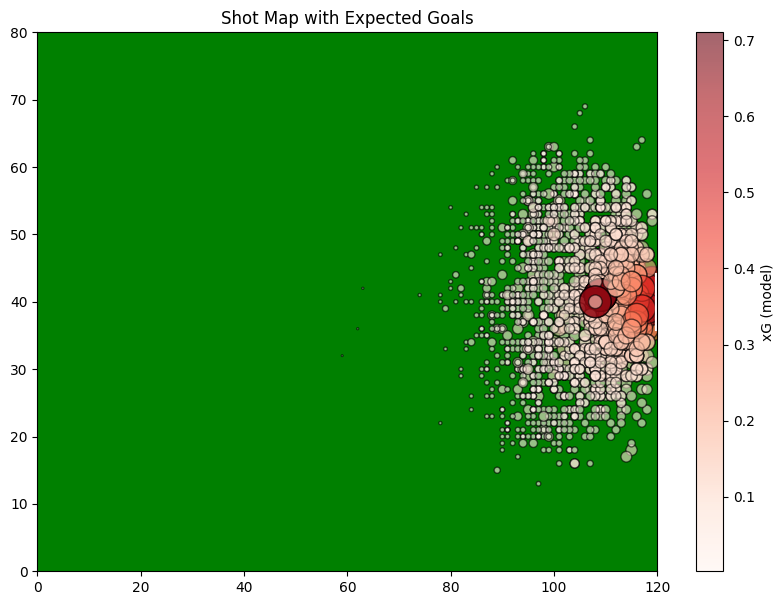

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlim(0,120)
ax.set_ylim(0,80)
ax.set_facecolor("green")
ax.plot([120,120],[36,44],color="white",linewidth=3)

sc = ax.scatter(
    shots["location"].str[0],
    shots["location"].str[1],
    c=shots["xG_model"],
    s=shots["xG_model"]*800,
    cmap="Reds",
    alpha=0.6,
    edgecolor="black"
)

plt.colorbar(sc, label="xG (model)")
plt.title("Shot Map with Expected Goals")
plt.show()
